# Twitter Data Extraction 

Module Code: **CS3PP19**

Assignment Report Title: **Twitter Data Extraction**

Student Numbers: **28010336, 28012606, 28006461**

Date Completed: **29/11/2021** 

Actual hours spent for the assignment: **16 hours**

Assignment evaluation (3 key points):  
1. We learnt how to extract data using tweepy.
2. We understood how to perform an EDA.
3. We learnt how to create a network based on the data.

# Introduction

In this data analysis task, we will analyse 3 selected Twitter accounts. Task 1; we data from twitter regarding, processing it into Pandas dataframes along with cleansing them down to crtical data only to reduce the size of our dataset. Task 2 merges all the data from the accounts and performs an explroatory data analysis (EDA) on the conjoined data in order to examine their characteristics. Specifically, we intend to analyse the following:

- Follower to following ratio (including the individual counts of each) plotted as a percentage bar of the ratio
- Activity share (status updates, retweets, favourites) represented as a piechart
- Most popular mentions
- Number of accounts that they are following
- Number of followers
- Number of original tweets that were posted
- Number of likes that each original tweet has
- Number of times that each original tweet have been retweeted
- Number of retweets that were posted by the user
- Number of tweets that the users have liked

Finally, task 3 creates a bi-directional graph of each account's area of influence - consituted of their followers and followings - in order to analyse the network of each account.

# Task 1 - Data Gathering and Pre-processing

Our 3 accounts' names are stored as a list for use throughout the notebook

In [1]:
accountNames = ["iJustine", "BarackObama", "LeoDiCaprio"]
accountIndices = {accountNames[0]: 0, accountNames[1]: 1, accountNames[2]: 2}
accountIDs = {} # Populated in data extraction

## API connection

Using Tweepy, we use our twitter developer account’s bearer token to authorise it’s usage and create an instance of Tweepy API v2 using *Client()*

https://docs.tweepy.org/en/stable/auth_tutorial.html

In [ ]:
import tweepy

# The bearer token of our developer account
bearer = 'AAAAAAAAAAAAAAAAAAAAANiSVwEAAAAAaKxCBHUoe37A5VmVITnP%2FVQXtus%3DH71897v17xZqYvlc5Qh5uLHbpSyvaLGIElaBvBaPXGtI3tmMWP'

# Create and store a Tweepy client instance using our authroisation token. Also, set the rate_limit flag to true.
client = tweepy.Client(bearer_token=bearer, wait_on_rate_limit=True)

Using the Tweepy Client object, we extract basic information from Twitter, such as account ID's, metrics, and creation date.

https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user

In [ ]:
# Create a list for usernames of the users to request data for
usernameList = accountNames[0]

# Populate list with the usernames in the required format
index = 0
for name in accountNames:
    if(index == 0):
        continue
        
    usernameList += ","
    usernameList += name

# Retrieve the user data
users = client.get_users(
    usernames="iJustine,BarackObama,LeoDiCaprio", 
    user_fields=['id', 'name', 'public_metrics', 'created_at']
).data

## Data extraction

In the data extraction stage, we collect all data we require from the Twitter API for our analysis purposes.

; for us, we define this as a set of API calls and selecting the raw data from which we will use - reducing the size our dataset(s).

In order to obtain the following list, we searched the api documentation of Tweepy (https://docs.tweepy.org/en/stable/api.html) and sought at methods which can acquire useful data of an account. These methods are:
- Friends - get_friends()
- Followers - get_followers()
- Posts - user_timeline()
- Retweets - get_retweets(), get_retweets_of_me()
- Likes - get_favourites()

**Should this only be in task 2's explanation, to not have duplication and because some of this data requires processing, thus now raw data?**

The list below shows all the raw data that we will be extracting from the accounts:
- Number of accounts that they are following. - Following Count
- Number of followers. - Follower count
- Number of original tweets that were posted. - Original tweet count
- Number of likes that each original tweet has. - original tweet like count
- Number of times that each original tweet have been retweeted. - original tweet retweet count
- Number of retweets that were posted by the user. - retweet count


- Number of tweets that the users have liked.


- Number of times that the accounts were mentioned.


In [ ]:
import pandas as pd

# Set options regarding Pandas's display of dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# https://developer.twitter.com/en/docs/twitter-api/rate-limits

class RawUserData:
    
    # Maximum limits
    MAX_TWEETS = 300
    MAX_FOLLOWERS = 100
    MAX_FOLLOWING = 100
    
    # User information
    userID = None
    username = None # The username of the account this UserData represents
    dateJoined = None # The date the account was created
    
    # Metrics
    followingCount = None # The number of people this account follows
    followersCount = None # The number of people following this account
    tweetCount = None # The number of tweets this account has made
    likesCount = None # The number of likes the account has done
    retweetCount = None # The number of retweets the account has done
    mentionCount = None # The number of times this account has mentioned someone/something in a tweet
    
    # User activity
    tweets = [] # The tweets this account has made (original tweets)
    
    # Network
    followers = [] # The followers the account has
    following = [] # The friends the account has
    
    # RawData constructor
    def __init__(self, user): 
        self.userID = user.id
        self.name = user.name
        self.followingCount = user.public_metrics['following_count']
        self.followersCount = user.public_metrics['followers_count']
        self.tweetCount= user.public_metrics['tweet_count']
        self.likesCount = user.public_metrics['tweet_count']
        self.dateJoined = user.created_at.strftime('%d-%m-%Y')
        
        # Get tweets using pagination
        self.tweets = self.paginate(client.get_users_tweets, self.MAX_TWEETS)
                
        # Get followrs and followings using pagination
        self.followers = self.paginate(client.get_users_followers, self.MAX_FOLLOWERS)
        self.following = self.paginate(client.get_users_following, self.MAX_FOLLOWING)

    # Display a summary of the acquired information
    def display(self):        
        print(f"{self.name}:\n"
              f"\t- Friends: {self.followingCount}\n"
              f"\t- Followers: {self.followersCount}\n"
              f"\t- Tweets: {self.tweetCount}\n"
              f"\t- Likes: {self.likesCount}\n"
              f"\t- Data Joined: {self.dateJoined}\n"
              f"\t- Retrieved {len(self.tweets)} tweets")

    # Pagination allows the program to retrieve more than the default limit of records.
    # This method abstracts the process of pagiation down to a method and a count limit
    def paginate(self, method, maxCount):
        return [record for record in tweepy.Paginator(
            method, 
            id=self.userID,
            tweet_fields=['id', 'author_id', 'text', 'entities', 'created_at', 'public_metrics'],
            max_results=100)
        .flatten(limit=maxCount)] # Might have to say the max count here again
    

## Data cleaning
*From the selected data, we resolve any missing values, duplicated occurences, etc.*

In preperation for the next stage of pre-processing of the data.

This step is crucial in ensuring the resultant final information extracted is accurate and reliable. Furthermore, cleaning the data extracted allows for pre-processing to be a simpler and more reliable process as duplicate or missing values are resolved.

In [ ]:
# Go through each account extracting the required data and their raw contents as a UserData object
rawUserData = [RawUserData(user) for user in users]

Populate the *accountIDs* dictionary and display the general information acquired

In [ ]:
for rawData in rawUserData:
    accountIDs[rawData.userID] = rawData.name
    rawData.display()

In [ ]:
# Now clean this data
# If a tweet has no hashtags, ensure it's initialised empty list, not an unknown value, and the same for mentions, likes, etc.
# Format the date in the same way for all uses of date

## Data pre-processing
The pre-processing stage of data extraction requires the selected raw data be prepared for analysis. To do so, we transform the cleaned raw data into Pandas data frames which can be done almost directly as the data was cleaned in the previous stage.

*Note: A account's followers ar*

For an account:

**Account**

A user is represented by their user ID. 

A user entry stores their account name, join date, and their friends and followers' IDs

| ID | Account Name | Date Joined | Follower IDs | Friend IDs |
| -- | ------------ | ----------- | ------------ | ---------- |

**Status**

A status is index'd by a composite key, made up ofa pimary unique ID (tweet_id) and a secondary shared ID with the account that made the status.

Mentions and hashtags are a CSV list of account ID's or plain text repsectively.

Likes and retweets are foriegn keys into their respective Pandas dataframes.

A status can be a tweet, retweet or favourite (like)

| ID | Account ID | Text | Mentions | Hashtags | Likes | Retweets | Comments | Date | Type |
| -- | ---------- | ---- | -------- | -------- | ----- | -------- | -------- | ---- | ---- |



# Task 2 - Exploratory Data Analysis (EDA)

To perform our exploratory data analysis, we create a class to represent our dataset. Our reasoning for wrapping a Pandas dataframe is multiple:

1. Our data is organised in the manner of a 3rd normal form database, as such, there are multiple dataframes to reduce data redundancy and duplication. Having a wrapper for these dataframes allows a single method be written that completely encapsulates that functionality.
2. Creating the dataset requires multiple pieces of re-used functionality - requring functions. However, these functions all operate in a specific order, always on the same data - i.e., it's a specific type. Therefore, our dataset class can be seen as inheriting dataframe functionality to produce a more complete dataset system.

In [15]:
# Take the RawUserData of an account and transform it into Pandas dataframes

class TweetType:
    
    ORIGINAL = 1
    REPLY = 2
    RETWEET = 4
    QUOTE = 8
    
    mask = 0
    
    def __init__(self, isReply, isRetweet, isQuote):
        self.mask |= (isReply << 1)
        self.mask |= (isRetweet << 2)
        self.mask |= (isQuote << 3)
        
        if self.mask == 0:
            self.mask = self.ORIGINAL

class Dataset:
    
    rawData = None
    
    accountFrame = pd.DataFrame(columns=["account_id", "name", "dateJoined", "follower_ids", "friend_ids"])
    statusFrame = pd.DataFrame(columns=["status_id", "account_id", "text", "mentions", "hashtags", "likes", "retweets", "date", "type"])
    
    accountFrame.set_index("account_id")
    statusFrame.set_index(["status_id", "account_id"])
            
    def addAssociatedAccounts(self, rawUser):
        
        followerIDs = []
        friendIDs = []
        
        for follower in rawUser.followers:

            # If account is already added, skip
            if(follower.id in self.accountFrame.account_id):
                continue
            
            followerIDs.append(follower.id) # Add follower to the user's follower's ID list
            
            self.addAccountFromUser(follower)
            
        for friend in rawUser.following:
            
            # If account is already added, skip
            if(friend.id in self.accountFrame.account_id):
                continue
            
            friendIDs.append(friend.id) # Add friend to the user's friend's ID list
 
            self.addAccountFromUser(friend)
            
            
        # Return tuple of follower and friend IDs that were added
        return (followerIDs, friendIDs)

    def addAccountFromData(self, accountData):
        self.accountFrame = self.accountFrame.append(accountData, ignore_index=True)
      
    def addAccountFromUser(self, user):       
        accountData = {
            "account_id": user.id,
            "name": user.name,
            "dateJoined": None,#user.created_at.strftime('%d-%m-%Y'),
            "follower_ids": None, 
            "friend_ids": None
        }
        
        self.addAccountFromData(accountData)

    def addStatus(self, statusData):
        self.statusFrame = self.statusFrame.append(statusData, ignore_index=True)
    
    def __init__(self, userData):
        self.rawData = userData

        # For all user data extracted
        for data in self.rawData:
            
            # First add their friend's and follower's accounts and save their IDs
            associatedUsers = self.addAssociatedAccounts(data)
            
            # Configure insertion data
            accountData = {
                "account_id": data.userID,
                "name": data.name,
                "dateJoined": data.dateJoined,
                "follower_ids": associatedUsers[0], 
                "friend_ids": associatedUsers[1]
            }
            
            # Add user account and their friend and follower's IDs
            self.addAccountFromData(accountData)
                        
            # For all statuses this account has made
            for tweet in data.tweets:
                
                #print(type(tweet))
                #print(tweet.in_reply_to_user_id)
                #print(hasattr(tweet, 'retweeted_status'))
                #print(hasattr(tweet, 'is_quote_status'))
                
                # Configure status data
                statusData = {
                    "status_id": tweet.id,
                    "account_id": tweet.author_id, 
                    "text": tweet.text, 
                    "mentions": self.getEntityAttributes(tweet.entities, 'mentions', 'username'), 
                    "hashtags": self.getEntityAttributes(tweet.entities, 'hashtags', 'tag'), 
                    "likes": tweet.public_metrics['like_count'], 
                    "retweets": tweet.public_metrics['retweet_count'], 
                    "reply": tweet.public_metrics['reply_count'],
                    "date": tweet.created_at.strftime('%Y %m %d')
                }
                                
                self.addStatus(statusData)
            
    def getEntityAttributes(self, entities, entityKey, attributeKey):
        if entities:
            if entityKey in entities:
                return [entity[attributeKey] for entity in entities[entityKey]]
        
        return []
            
dataset = Dataset([rawUser for rawUser in rawUserData])

display(dataset.accountFrame)
display(dataset.statusFrame)


,account_id,name,dateJoined,follower_ids,friend_ids
0,1445658550865440768,soletuandrea,None,None,None
1,1444995191916482561,Gowri Aaradhana 🍁,None,None,None
2,1269253719432052737,Alexei Eduardo Vieira,None,None,None
3,1465265140765380609,Zone Supper,None,None,None
4,1464891516619411459,Dipu Kazi,None,None,None
5,1445063878283386888,Eternal Jake,None,None,None
6,773866880826281984,M&M,None,None,None
7,1454424972491776007,"Drones,Action Cameras And More",None,None,None
8,860084378180898816,Deven Nehete,None,None,None
9,1461976395362578434,Ali,None,None,None


,status_id,account_id,text,mentions,hashtags,likes,retweets,date,type,reply
0,1465119036782432259,7846,@andrearene @WhatsGood_Games @johntdrake @Logi...,"[andrearene, WhatsGood_Games, johntdrake, Logi...",[],11,0,2021 11 29,NaN,1.0
1,1465091806287171584,7846,@RDRv3 Are they having a lottery for the boost...,[RDRv3],[],4,0,2021 11 28,NaN,0.0
2,1465091645217525765,7846,@perry_wes I found another one that was even b...,[perry_wes],[],1,0,2021 11 28,NaN,1.0
3,1465091435724640256,7846,@LizeyMay Hahaha there are actually 5 of them ...,[LizeyMay],[],1,0,2021 11 28,NaN,0.0
4,1465091316174372864,7846,@DigitalDvnprt @jennaezarik Haha honestly most...,"[DigitalDvnprt, jennaezarik]",[],1,0,2021 11 28,NaN,1.0
5,1465091197198733316,7846,@javajoint Hahahahahah,[javajoint],[],1,0,2021 11 28,NaN,0.0
6,1465091139623555076,7846,@RogueHunter65 @jennaezarik I feel better now,"[RogueHunter65, jennaezarik]",[],7,0,2021 11 28,NaN,0.0
7,1465000813986680834,7846,Jenna just told me I have a sickness..\n\n@jen...,[jennaezarik],[],1608,32,2021 11 28,NaN,70.0
8,1464995940809383939,7846,@ChekTek I know,[ChekTek],[],4,0,2021 11 28,NaN,1.0
9,1464995877353779204,7846,@TravisMcP Great point…,[TravisMcP],[],14,0,2021 11 28,NaN,0.0


## Statistics

Follower and following totals are plotted against eachother in a bar chart to display the differences between our three different type of influencer's accounts
 
The reasoning for these analysis' represents the principle of EDA. We delibriately chose 3 different "types" of influencers (political, ameteur entertainment, professional actor) in order to analyse the differences between these types. We are curious about the basic information, like ratios between:

- Followers and following
- Tweet and retweets, 
- Likes and retweets on their tweets. 
- Most popular mentions
- Most popular hashtags

Furthermore, we intend to analyse more complex statistics such as:

- Percentage of activity on an account (favourites, comments, retweets) and if they are followed or not **- TODO**
 - Activity share (status updates, retweets, favourites) represented as a piechart **- TODO**

On-top of these more complex statistics, we will also plot basic metrics of the accounts, such as their number of:

- Accounts that they are following
- Followers
- Original tweets that were posted
- Likes that each original tweet has
- Times that each original tweet have been retweeted
- Retweets that were posted by the user
- Tweets that the users have liked
- Replies on their tweets
- Most popular tweets

To achieve this, another class is defined ("DataSetAnalyser") which takes a dataset and a target and returns through numerous methods, data from that dataset which applies to the target(s)

In [16]:
import matplotlib.pyplot as plt

#plt.autoscale(enable=True, axis="x", tight=True)
#plt.tick_params(axis='x', which='major', labelsize=8)

plt.rcParams["figure.figsize"] = [7.5, 4.0]
plt.rcParams["figure.autolayout"] = True
    
class DataSetAnalyser():
    
    ds = None # Dataset
    t = None # Target
    
    # Initialises class with the dataset
    def __init__(self, dataset):
        self.ds = dataset
        
    # Sets target t the accounts passed, handling special cases too
    # If valid list is passed, t is set to the list
    # If a value is passed, t is set to a list of one
    # If nothing is passed, t is set to all accounts
    def setTarget(self, accounts = None):
        if type(accounts) is not list:
            if accounts is None:
                self.t = [user.userID for user in rawUserData]
            else:
                self.t = [accounts]
            
        t = accounts
    
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
        # Has a non-empty list of mentions 
    # The mentions from this filtered dataframe are extracted
    # Finally, the resulting series is "exploded", which expands any lists into their own records - so that DataFrame.value_counts() can be used to count the frequency
    def getMentions(self):        
        mentions = self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t) & self.ds.statusFrame["mentions"].astype(bool)]
                
        return mentions["mentions"].explode()
    
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
        # Has a non-empty list of hashtags 
    # The hashtags from this filtered dataframe are extracted
    # Finally, the resulting series is "exploded", which expands any lists into their own records - so that DataFrame.value_counts() can be used to count the frequency
    def getHashtags(self):        
        hashtags = self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t) & self.ds.statusFrame["hashtags"].astype(bool)]
                
        return hashtags["hashtags"].explode()
            
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
    # Returns the retweet count for each record that matched 
    def getRetweets(self):
        return self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t)]["retweets"]
      
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
    # Returns the like count for each record that matched
    def getFavourites(self):
        return self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t)]["likes"]
    
    # Selects all records which satisifies the criteria:
        # Usernames are present in the target list
    # Returns the reply count for each record that matched
    def getReplies(self):
        return self.ds.statusFrame[self.ds.statusFrame["account_id"].isin(self.t)]["reply"]

    def getFollowingList(self):
        return self.ds.accountFrame[self.ds.accountFrame["account_id"].isin(self.t)]["friend_ids"].tolist()[0]
    
# Create instance of the analyser class
analyser = DataSetAnalyser(dataset)

### Data Plotting

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


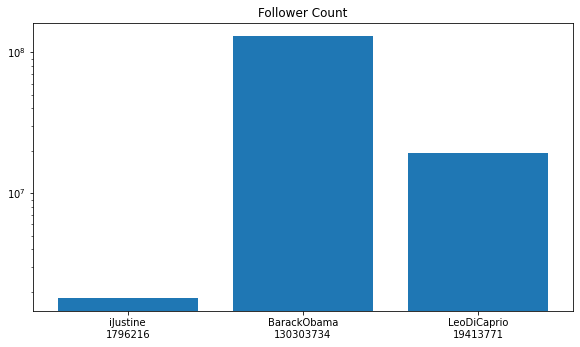

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


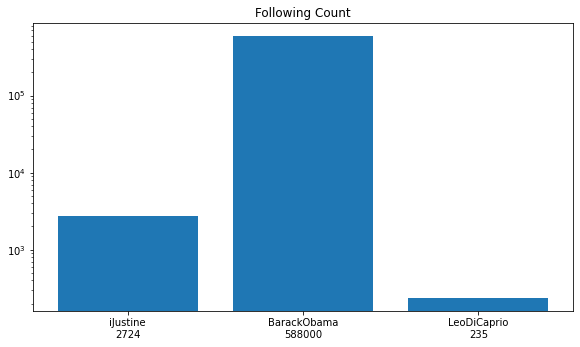

Follower / Following Ratio

iJustine: 659.4038179148312
BarackObama: 221.60498979591836
LeoDiCaprio: 82611.7914893617


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


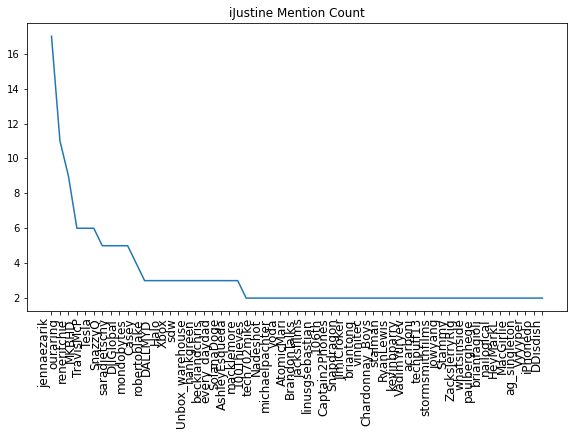

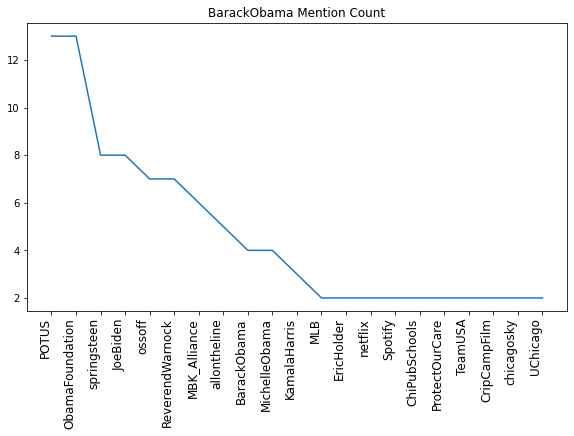

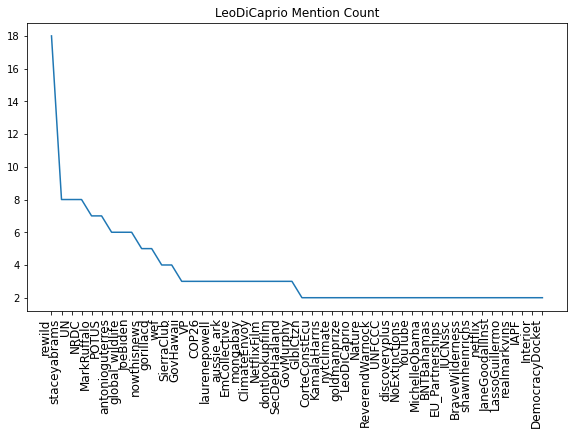

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


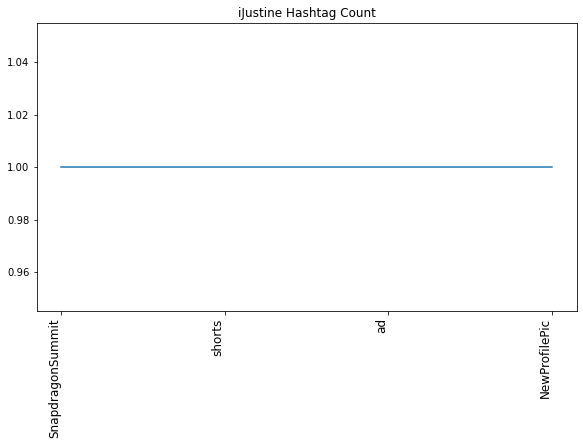

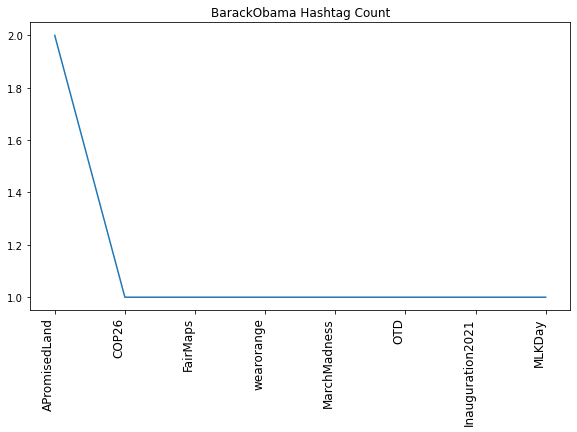

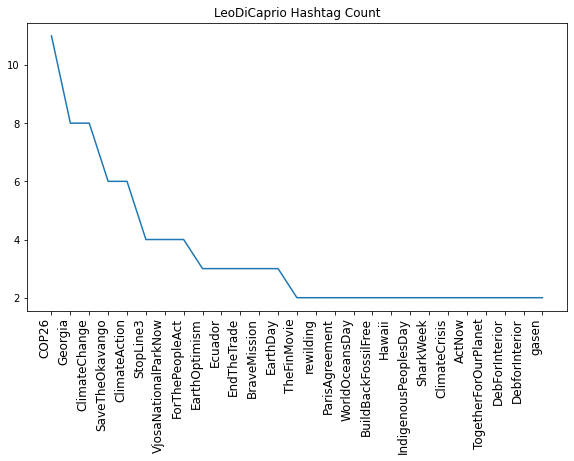

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


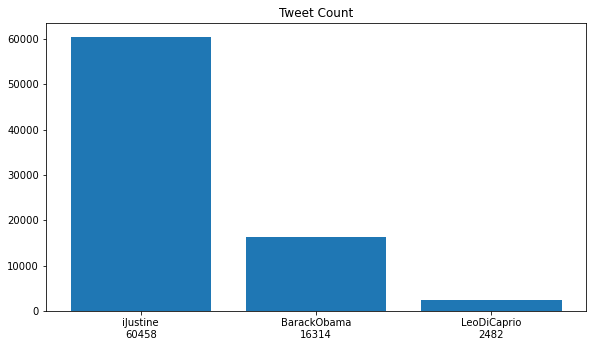

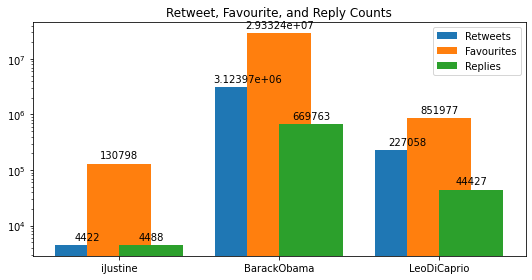

In [17]:
import numpy as np

# Follower counts
followerCountFig = plt.figure()
axFollowers = followerCountFig.add_axes([0,0,1,1])
axFollowers.set_title("Follower Count")
axFollowers.set_yscale('log')

values = [rawUserData[index].followersCount for index in range(len(rawUserData))]
labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accountNames[i]}\n{values[i]}")

axFollowers.bar(labels, values)
plt.show()

# Following counts
followingCountFig = plt.figure()
axFollowing = followingCountFig.add_axes([0,0,1,1])
axFollowing.set_title("Following Count")
axFollowing.set_yscale('log')

values = [rawUserData[index].followingCount for index in range(len(rawUserData))]
labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accountNames[i]}\n{values[i]}")

axFollowing.bar(labels, values)
plt.show()

# Follower / Following Ratio
print("Follower / Following Ratio")
print()
for i in range(len(rawUserData)):
    print(f"{accountNames[i]}: {(rawUserData[i].followersCount / rawUserData[i].followingCount)}")
    
# Function for plotting mention freuqnecies
def plotMentions(plot, userIndex):    
    plot.subplots_adjust(top=5, bottom=4.9)
    
    ax = plot.add_axes([0,0,1,1])
    ax.set_title(f"{accountNames[userIndex]} Mention Count")

    analyser.setTarget(rawUserData[userIndex].userID)
    mentionCounts = analyser.getMentions().value_counts()
    index = 0
    for count in mentionCounts:
        if count == 1:
            break
        index+=1
    labels = mentionCounts.index[:index]
    values = mentionCounts[:index]

    ax.plot(labels, values)
    
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='large')
    
plotMentions(plt.figure(), 0)
plotMentions(plt.figure(), 1)
plotMentions(plt.figure(), 2)
plt.show()

# Function for plotting hashtag freuqnecies
def plotHashtags(plot, userIndex):    
    plot.subplots_adjust(top=5, bottom=4.9)
    
    ax = plot.add_axes([0,0,1,1])
    ax.set_title(f"{accountNames[userIndex]} Hashtag Count")

    analyser.setTarget(rawUserData[userIndex].userID)
    hashtagCounts = analyser.getHashtags().value_counts()
    index = 0
    for count in hashtagCounts:
        if count == 1:
            if(index < 3):
                index = 10
            break
        index+=1
    labels = hashtagCounts.index[:index]
    values = hashtagCounts[:index]

    ax.plot(labels, values)
    
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='large')

plotHashtags(plt.figure(), 0)
plotHashtags(plt.figure(), 1)
plotHashtags(plt.figure(), 2)  
plt.show()
    
# Values for tweet counts, and their retweet, favourite and reply count
tweetValues = [rawUserData[index].tweetCount for index in range(len(rawUserData))]
retweetValues = []
favouriteValues = []
replyValues = []
for userID in accountIDs.keys():
    analyser.setTarget(userID) # Set the analyser's target to the current loop iteration value
    retweetValues.append(analyser.getRetweets().explode().sum())
    favouriteValues.append(analyser.getFavourites().explode().sum())
    replyValues.append(analyser.getReplies().explode().sum())
# Tweet count
tweetCountFig = plt.figure()
axTweetCount = tweetCountFig.add_axes([0,0,1,1])
axTweetCount.set_title("Tweet Count")

labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accountNames[i]}\n{tweetValues[i]}")
    
axTweetCount.bar(labels, tweetValues)
plt.show()

# Combined statistics
labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accountNames[i]}")

x = np.arange(len(labels))
width = 0.4

combinedTweetStatFig, axCombinedTweetStat = plt.subplots()
retweetRects   = axCombinedTweetStat.bar(x - width/2, retweetValues,   width, label="Retweets")
favouriteRects = axCombinedTweetStat.bar(x          , favouriteValues, width, label="Favourites")
replyRects     = axCombinedTweetStat.bar(x + width/2, replyValues,     width, label="Replies")

axCombinedTweetStat.set_title("Retweet, Favourite, and Reply Counts")
axCombinedTweetStat.set_xticks(x)
axCombinedTweetStat.set_xticklabels(labels)
axCombinedTweetStat.set_yscale("log")
axCombinedTweetStat.legend()
axCombinedTweetStat.bar_label(retweetRects, padding=3)
axCombinedTweetStat.bar_label(favouriteRects, padding=3)
axCombinedTweetStat.bar_label(replyRects, padding=3)
plt.show()

## EDA Conclusion

Through the EDA process, a number of conclusions can be drawn, some of which quite informative.

Firstly, the number of tweets made by each individual expoentially increases from Leonardo DiCaprio, Barack Obama and iJustine. Which is unintriguing by itself, when it's compared against the number of retweets, favourites and replies on tweets, is does become interesting information. The exponenial curve almost completely flips, with iJustine now comfortably with the least counts of all three statistics and Barack Obama with almost twice as many counts on all statistics as DiCaprio's.

Some exploratory theories can be produced from these statistics, such as:
- Obama dominates the counts between the other two types of infuencers, leading to a potential hypothesis there is more interaction with political/world matters than individual matters (like that of iJustine). However this could be quickly disproved with the consideration of time-period of the 300 tweets analysed.
- DiCaprio's counts hover around half of Obama's while having over 6 times less tweets. This would suggest while Obama has the most interaction with his tweets, DiCaprio gets more attraction per individual tweet. This could be proven with averaging the sum of the counts after totalling them. 

## Further Analysis from the EDA Conclusioon

To analyse the points brought up from the conclusion and the lessons learned, further analysis is conducted stemming from the conclusion of the EDA.

We firstly learned that multiple representations of a particular piece of data is important for a clear and valid hypothesis of it's occurence. Therefore, we implement the analysis of the mean and highest to back our findings in the conclusion.

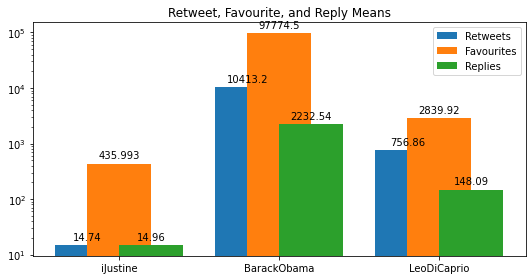

Retweet, Favourite, and Reply Max Values

iJustine:
	- Retweet: 432
	- Favourite: 10262
	- Reply: 374.0
BarackObama:
	- Retweet: 303165
	- Favourite: 2761795
	- Reply: 38689.0
LeoDiCaprio:
	- Retweet: 11526
	- Favourite: 50076
	- Reply: 1648.0


In [18]:
labels = []
for i in range(0, len(accountNames)):
    labels.append(f"{accountNames[i]}")

retweetValueList = []
favouriteValueList = []
replyValueList = []

retweetMean = []
retweetMax = []
favouriteMean = []
favouriteMax = []
replyMean = []
replyMax = []


index = 0
for userID in accountIDs.keys():
    analyser.setTarget(userID) # Set the analyser's target to the current loop iteration value
    
    retweetValueList.append(analyser.getRetweets().explode())
    favouriteValueList.append(analyser.getFavourites().explode())
    replyValueList.append(analyser.getReplies().explode())
    
    retweetMean.append(retweetValueList[index].sum() / len(retweetValueList[index]))
    retweetMax.append(retweetValueList[index].max())
    
    favouriteMean.append(favouriteValueList[index].sum() / len(favouriteValueList[index]))
    favouriteMax.append(favouriteValueList[index].max())
    
    replyMean.append(replyValueList[index].sum() / len(replyValueList[index]))
    replyMax.append(replyValueList[index].max())
    
    index+=1
    
# Tweet mean values
x = np.arange(len(labels))
width = 0.4

combinedTweetStatFigNew, axCombinedTweetStatNew = plt.subplots()
retweetRects   = axCombinedTweetStatNew.bar(x - width/2, retweetMean,    width, label="Retweets")
favouriteRects = axCombinedTweetStatNew.bar(x          , favouriteMean, width, label="Favourites")
replyRects     = axCombinedTweetStatNew.bar(x + width/2, replyMean,     width, label="Replies")

axCombinedTweetStatNew.set_title("Retweet, Favourite, and Reply Means")
axCombinedTweetStatNew.set_xticks(x)
axCombinedTweetStatNew.set_xticklabels(labels)
axCombinedTweetStatNew.set_yscale("log")
axCombinedTweetStatNew.legend()
axCombinedTweetStatNew.bar_label(retweetRects, padding=3)
axCombinedTweetStatNew.bar_label(favouriteRects, padding=3)
axCombinedTweetStatNew.bar_label(replyRects, padding=3)

plt.show()

# Tweet Max Values
print("Retweet, Favourite, and Reply Max Values")
print()
for i in range(len(rawUserData)):
    print(f"{accountNames[i]}:\n\t- Retweet: {retweetMax[i]}\n\t- Favourite: {favouriteMax[i]}\n\t- Reply: {replyMax[i]}")

As can be seen from the further analysis, the previous hypothesis was correct from the original EDA conclusion - Obama does in fact get the most interaction with his tweets, even despite his smaller number of tweets.

# Task 3 - Network Analysis

For a given account, it has a bidrectional network of influence. That is, account A can interact with account B, but account B can also interact with account A.

Using NetworkX and the pre-processed PandasUserData information, we will create and explore a bi-directional network of each account.

Each node is an account unique Twitter user ID. Allowing for lookups from the graph into the dataset which uses the same ID to index it's records.

In [32]:
import networkx as nx
    
class Network:
    graph = None

    def __init__(self, centerNode, followingList):
        self.graph = nx.Graph()
            
        # Add the center node (influencer account) to the graph
        self.graph.add_node(centerNode)
                
        # Add the accounts the user is following to the graph
        for account in followingList:    
            self.graph.add_node(account) # Add the account ID to the graph
            self.graph.add_edge(centerNode, account) # Link the account with the influencer account
            

In [33]:
# Create a network for each account

networks = []

for account in accountIDs:
    analyser.setTarget(account)
    networks.append(Network(account, analyser.getFollowingList()))

We have created 3 circular graphs for visualisation of the networks.

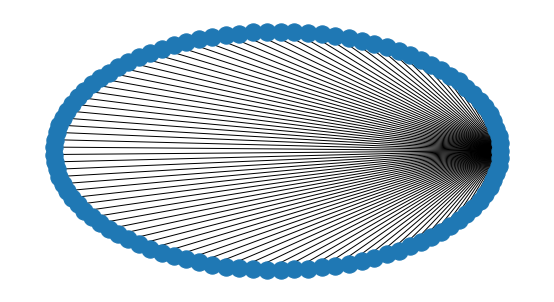

In [35]:
oGraph = networks[0].graph

nx.draw_circular(oGraph)

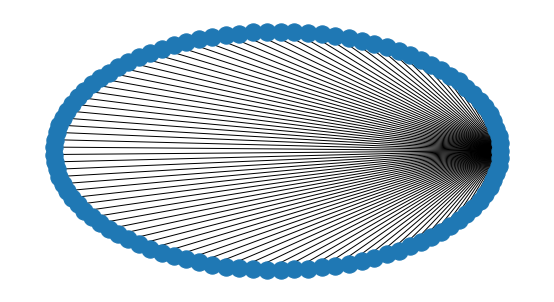

In [30]:
oGraph1 = networks[1].graph

nx.draw_circular(oGraph1)

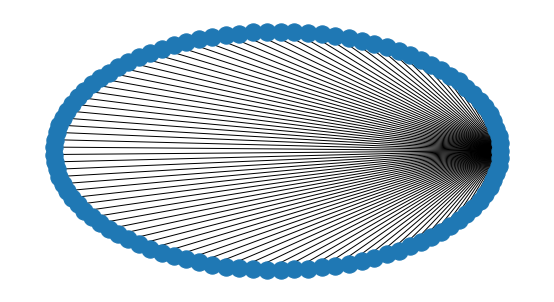

In [31]:
oGraph2 = networks[2].graph

nx.draw_circular(oGraph2)

3 samples of edge lists for each of the graphs are produced.

In [36]:
list(oGraph.edges)[None:10:None]

[(7846, 2538267829),
 (7846, 1386694282996715522),
 (7846, 18007213),
 (7846, 820673148295192577),
 (7846, 3496641),
 (7846, 1090141),
 (7846, 834400338312564736),
 (7846, 1300495749478785026),
 (7846, 1413608544142721024),
 (7846, 14053116)]

In [37]:
list(oGraph1.edges)[None:10:None]

[(813286, 1339835893),
 (813286, 3333055535),
 (813286, 842596570189234176),
 (813286, 3065569479),
 (813286, 43383705),
 (813286, 81163402),
 (813286, 1330457336),
 (813286, 30354991),
 (813286, 3157910605),
 (813286, 739119366)]

In [38]:
list(oGraph2.edges)[None:10:None]

[(133880286, 264057155),
 (133880286, 166196682),
 (133880286, 695015469212766208),
 (133880286, 306311289),
 (133880286, 513880574),
 (133880286, 14180138),
 (133880286, 1079443074),
 (133880286, 15667802),
 (133880286, 794651044450041856),
 (133880286, 3063996411)]

3 samples of neighbour lists for each of the graphs are produced.

In [39]:
lNeighbours = []

iCount = 0
for oNeighbour in oGraph.neighbors(7846):
    if iCount == 10:
        break
    lNeighbours.append(oNeighbour)
    print(oNeighbour)
    iCount += 1

2538267829
1386694282996715522
18007213
820673148295192577
3496641
1090141
834400338312564736
1300495749478785026
1413608544142721024
14053116


In [40]:
lNeighbours = []

iCount = 0
for oNeighbour in oGraph1.neighbors(813286):
    if iCount == 10:
        break
    lNeighbours.append(oNeighbour)
    print(oNeighbour)
    iCount += 1

1339835893
3333055535
842596570189234176
3065569479
43383705
81163402
1330457336
30354991
3157910605
739119366


In [41]:
lNeighbours = []

iCount = 0
for oNeighbour in oGraph2.neighbors(133880286):
    if iCount == 10:
        break
    lNeighbours.append(oNeighbour)
    print(oNeighbour)
    iCount += 1

264057155
166196682
695015469212766208
306311289
513880574
14180138
1079443074
15667802
794651044450041856
3063996411


## Analysis
We have calculated statistics of the network.

The degree of a node is the number of links it has to other nodes. The degree distribution is the probability distribution of these numbers over the whole network.

Degrees for oGraph: 100
Degrees for oGraph1: 100
Degrees for oGraph2: 100


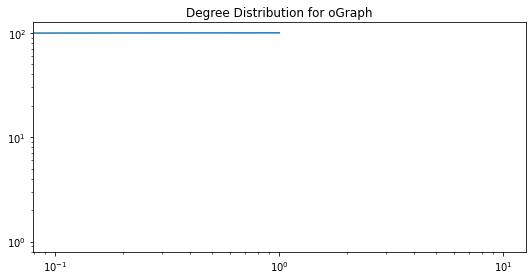

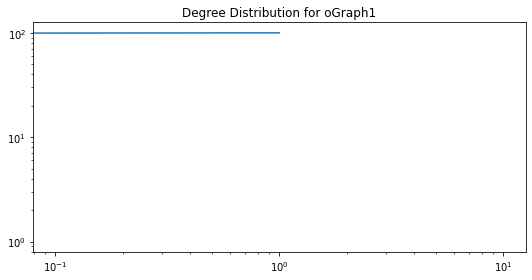

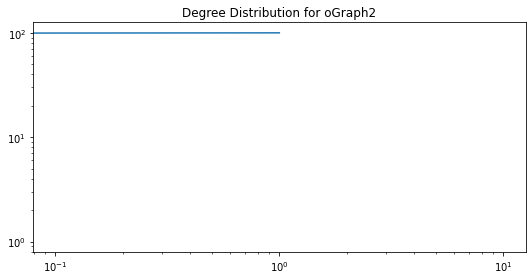

In [69]:
oDegrees = {}
oDegrees1 = {}
oDegrees2 = {}

print("Degrees for oGraph: " + str(nx.degree(oGraph, 7846)))
print("Degrees for oGraph1: " + str(nx.degree(oGraph1, 813286)))
print("Degrees for oGraph2: " + str(nx.degree(oGraph2, 133880286)))

for oNodes in oGraph.nodes():
    oDegree = oGraph.degree(oNodes)
    if oDegree not in oDegrees:
        oDegrees[oDegree] = 0
    oDegrees[oDegree] += 1
    oItems = sorted(oDegrees.items())
oFig = plt.figure()
oAx = oFig.add_subplot(111)
oAx.plot([k for (k, v) in oItems]), [v for (k, v) in oItems]
oAx.set_xscale('log')
oAx.set_yscale('log')
plt.title("Degree Distribution for oGraph")
plt.show()

for oNodes in oGraph.nodes():
    oDegree = oGraph.degree(oNodes)
    if oDegree not in oDegrees:
        oDegrees[oDegree] = 0
    oDegrees[oDegree] += 1
    oItems = sorted(oDegrees.items())
oFig = plt.figure()
oAx = oFig.add_subplot(111)
oAx.plot([k for (k, v) in oItems]), [v for (k, v) in oItems]
oAx.set_xscale('log')
oAx.set_yscale('log')
plt.title("Degree Distribution for oGraph1")
plt.show()

for oNodes in oGraph.nodes():
    oDegree = oGraph.degree(oNodes)
    if oDegree not in oDegrees:
        oDegrees[oDegree] = 0
    oDegrees[oDegree] += 1
    oItems = sorted(oDegrees.items())
oFig = plt.figure()
oAx = oFig.add_subplot(111)
oAx.plot([k for (k, v) in oItems]), [v for (k, v) in oItems]
oAx.set_xscale('log')
oAx.set_yscale('log')
plt.title("Degree Distribution for oGraph2")
plt.show()

To analyse the importance of a node as a percentage we can use the betweeness centrality measure; which calculates all the shortest paths which pass through a node.

In [43]:
nx.clustering(oGraph)

{7846: 0,
 2538267829: 0,
 1386694282996715522: 0,
 18007213: 0,
 820673148295192577: 0,
 3496641: 0,
 1090141: 0,
 834400338312564736: 0,
 1300495749478785026: 0,
 1413608544142721024: 0,
 14053116: 0,
 14661920: 0,
 50085192: 0,
 574032254: 0,
 59318218: 0,
 361384396: 0,
 3050707454: 0,
 1299965377355505666: 0,
 1573265498: 0,
 41777199: 0,
 1141757163045441536: 0,
 395514600: 0,
 41038781: 0,
 391037985: 0,
 23395456: 0,
 3289027731: 0,
 64931388: 0,
 134376725: 0,
 612076511: 0,
 544828911: 0,
 155768059: 0,
 18536658: 0,
 1118321164483473408: 0,
 308693201: 0,
 25694156: 0,
 490932793: 0,
 24871896: 0,
 168234688: 0,
 231534898: 0,
 300878069: 0,
 1102361186224336897: 0,
 1366471417181720578: 0,
 357267834: 0,
 2897431: 0,
 941091016731279361: 0,
 19202616: 0,
 898708204951031809: 0,
 17653553: 0,
 1076857425083408386: 0,
 281777578: 0,
 196066226: 0,
 1252051231331287049: 0,
 34442404: 0,
 956969150001197056: 0,
 146579141: 0,
 361871810: 0,
 1601374154: 0,
 48687278: 0,
 109058

In [44]:
nx.clustering(oGraph1)

{813286: 0,
 1339835893: 0,
 3333055535: 0,
 842596570189234176: 0,
 3065569479: 0,
 43383705: 0,
 81163402: 0,
 1330457336: 0,
 30354991: 0,
 3157910605: 0,
 739119366: 0,
 1111940934: 0,
 61636488: 0,
 22255654: 0,
 22712235: 0,
 346197350: 0,
 18509818: 0,
 419078608: 0,
 1944772783: 0,
 1575236180: 0,
 2922928743: 0,
 806862084277407744: 0,
 808823195298103297: 0,
 813772855586471937: 0,
 816277272013537280: 0,
 820354372827758592: 0,
 820378690920058880: 0,
 821419495730401281: 0,
 821172724701786112: 0,
 820830366713991168: 0,
 822086949552918529: 0,
 458525164: 0,
 2293315159: 0,
 169228393: 0,
 61409422: 0,
 1104425378: 0,
 1093090866: 0,
 818876014390603776: 0,
 98906881: 0,
 148322097: 0,
 111141045: 0,
 115979444: 0,
 88507556: 0,
 66873399: 0,
 311276757: 0,
 286234486: 0,
 49202580: 0,
 25896607: 0,
 389770689: 0,
 388513351: 0,
 14327933: 0,
 69295996: 0,
 42487860: 0,
 44238517: 0,
 770128646: 0,
 666073: 0,
 29450962: 0,
 939091: 0,
 402472046: 0,
 15667802: 0,
 8776808

In [50]:
print("Clustering coefficient for oGraph: " + str(nx.average_clustering(oGraph)))
print("Clustering coefficient for oGraph1: " + str(nx.average_clustering(oGraph1)))
print("Clustering coefficient for oGraph2: " + str(nx.average_clustering(oGraph2)))

Clustering coefficient for oGraph: 0.0
Clustering coefficient for oGraph1: 0.0
Clustering coefficient for oGraph2: 0.0


In [49]:
print("Betweenness Centrality for oGraph:\n" + str(nx.betweenness_centrality(oGraph)))
print("\nBetweenness Centrality for oGraph1:\n" + str(nx.betweenness_centrality(oGraph1)))
print("\nBetweenness Centrality for oGraph2:\n" + str(nx.betweenness_centrality(oGraph2)))

Betweenness Centrality for oGraph:
{7846: 1.0, 2538267829: 0.0, 1386694282996715522: 0.0, 18007213: 0.0, 820673148295192577: 0.0, 3496641: 0.0, 1090141: 0.0, 834400338312564736: 0.0, 1300495749478785026: 0.0, 1413608544142721024: 0.0, 14053116: 0.0, 14661920: 0.0, 50085192: 0.0, 574032254: 0.0, 59318218: 0.0, 361384396: 0.0, 3050707454: 0.0, 1299965377355505666: 0.0, 1573265498: 0.0, 41777199: 0.0, 1141757163045441536: 0.0, 395514600: 0.0, 41038781: 0.0, 391037985: 0.0, 23395456: 0.0, 3289027731: 0.0, 64931388: 0.0, 134376725: 0.0, 612076511: 0.0, 544828911: 0.0, 155768059: 0.0, 18536658: 0.0, 1118321164483473408: 0.0, 308693201: 0.0, 25694156: 0.0, 490932793: 0.0, 24871896: 0.0, 168234688: 0.0, 231534898: 0.0, 300878069: 0.0, 1102361186224336897: 0.0, 1366471417181720578: 0.0, 357267834: 0.0, 2897431: 0.0, 941091016731279361: 0.0, 19202616: 0.0, 898708204951031809: 0.0, 17653553: 0.0, 1076857425083408386: 0.0, 281777578: 0.0, 196066226: 0.0, 1252051231331287049: 0.0, 34442404: 0.0, 95

In [51]:
print("Assortativity for oGraph: " + str(nx.degree_assortativity_coefficient(oGraph, 'list')))
print("Assortativity for oGraph1: " + str(nx.degree_assortativity_coefficient(oGraph1, 'list')))
print("Assortativity for oGraph2: " + str(nx.degree_assortativity_coefficient(oGraph2, 'list')))

Assortativity for oGraph: -1.0
Assortativity for oGraph1: -1.0
Assortativity for oGraph2: -1.0
